<a href="https://colab.research.google.com/github/boomchilx/Machine-Learning-Notebooks/blob/main/birdclassification_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple classification using pytorch on Jetson Nano


In this notebook I will try to demonstate usage of pytorch for simple image classfication task. We will create a simple CNN and then try transfer learning using a pretrained model(ResNet18)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models

In [ ]:
# Get the available device

if torch.cuda.is_available():
    dev = "cuda:0"  # Gpu
else:
    dev = "cpu"
device = torch.device(dev)

### Utilities for loading training and testing image dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


trainset = torchvision.datasets.ImageFolder(root="birds/train/", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(root="birds/test/", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=False)

dataloaders = {
    "train": trainloader,
    "test": testloader
}
datasizes = {
    "train": len(trainset),
    "test": len(testset)
}
CLASSES = list(trainset.class_to_idx.keys())

In [ ]:
def imshow(img, size=(10, 10)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("One mini batch")
    plt.axis("off")
    plt.pause(0.001)

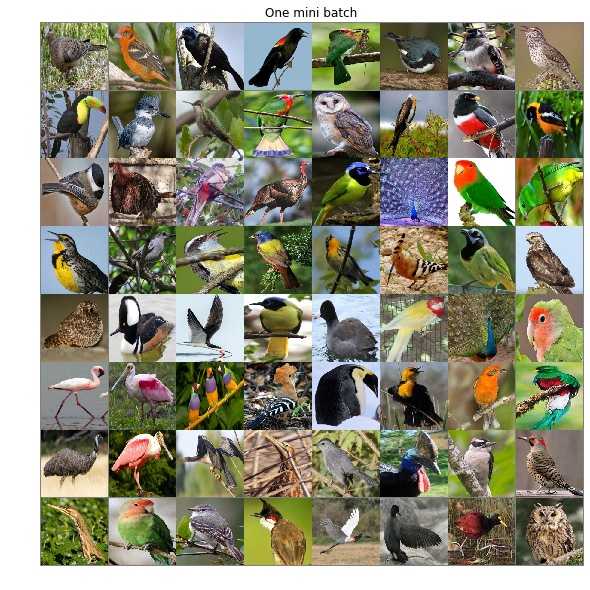

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Defining a simple CNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*53*53, 2809)
        self.fc2 = nn.Linear(2809, 512)
        self.fc3 = nn.Linear(512, len(CLASSES))
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=2809, bias=True)
  (fc2): Linear(in_features=2809, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=150, bias=True)
)

### Training simple CNN

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
for epoch in range(2):
    running_loss = 0.0
    best_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        corrects = torch.sum(preds == labels.data)
        # print Running loss
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    print("Epoch: {} Accuracy: {}".format(epoch, corrects.double()/datasizes["train"]))

[1,   100] loss: 5.000
[1,   200] loss: 4.725
[1,   300] loss: 4.230
Epoch: 0 Accuracy: 0.00045514311722463845
[2,   100] loss: 3.793
[2,   200] loss: 3.605
[2,   300] loss: 3.430
Epoch: 1 Accuracy: 0.0009102862344492769


As we can see, we did not get a good accuracy at all and will not get a good one from this model, because model is not upto the mark to do classification of 150 classes.

So we will use a pretrained model and edit its last fully connected layer and train ONLY that last layer.
We will use generic model training function form pytorch documentation (because its all we need, no changes at all)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs-1))
        print("-"*10)
        
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0 
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parametsrs
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / datasizes[phase]
            epoch_acc = running_corrects.double()/datasizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            if(phase == "test" and epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:0f}m {:0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best val Acc: {}:4f".format(best_acc))
    
    # load best model parameters
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)

# turn training false for all layers, other than fc layer
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(CLASSES))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.003, momentum=0.9)
exp_lr_sc = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_sc, epochs=5)

Epoch 0/4
----------
train Loss: 3.3955 Acc: 0.4104
test Loss: 1.8791 Acc: 0.7813

Epoch 1/4
----------
train Loss: 1.5780 Acc: 0.7975
test Loss: 0.9835 Acc: 0.9093

Epoch 2/4
----------
train Loss: 1.0329 Acc: 0.8632
test Loss: 0.6697 Acc: 0.9307

Epoch 3/4
----------
train Loss: 0.7983 Acc: 0.8849
test Loss: 0.5209 Acc: 0.9427

Epoch 4/4
----------
train Loss: 0.6678 Acc: 0.9002
test Loss: 0.4276 Acc: 0.9547

Training complete in 6.000000m 25.872093s
Best val Acc: 0.9546666666666667:4f


### Pretrained Results

In only 4-5 epochs we crossed 94% accuracy , without even breaking a sweat.
We can improve it further by 
1. More data augmentation and transformation while loading like Rotating image randomly, or Cropped selection and Scaled to make model more scale and rotate invariant
2. Fine tune model by playing with learning rate, and number of epochs
etc

In [ ]:
def imshowaxis(ax, img, orig, pred):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if orig != pred:
        ax.set_title(orig + "\n" + pred, color="red")
    else:
        ax.set_title(orig + "\n" + pred)
    ax.axis("off")


def vis_model(model, num_images=25):
    was_training = model.training
    model.eval()
    images_so_far = 0
    figure, ax = plt.subplots(5, 5, figsize=(20, 20))
    
    
    with torch.no_grad():
        for i , (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for i in range(5):
                for j in range(5):
                    if images_so_far < num_images:
                        imshowaxis(ax[i][j], inputs.cpu().data[images_so_far], CLASSES[labels[images_so_far]], CLASSES[preds[images_so_far]])
                    else:
                        model.train(mode=was_training)
                        return
                    images_so_far += 1
        model.train(mode=was_training)


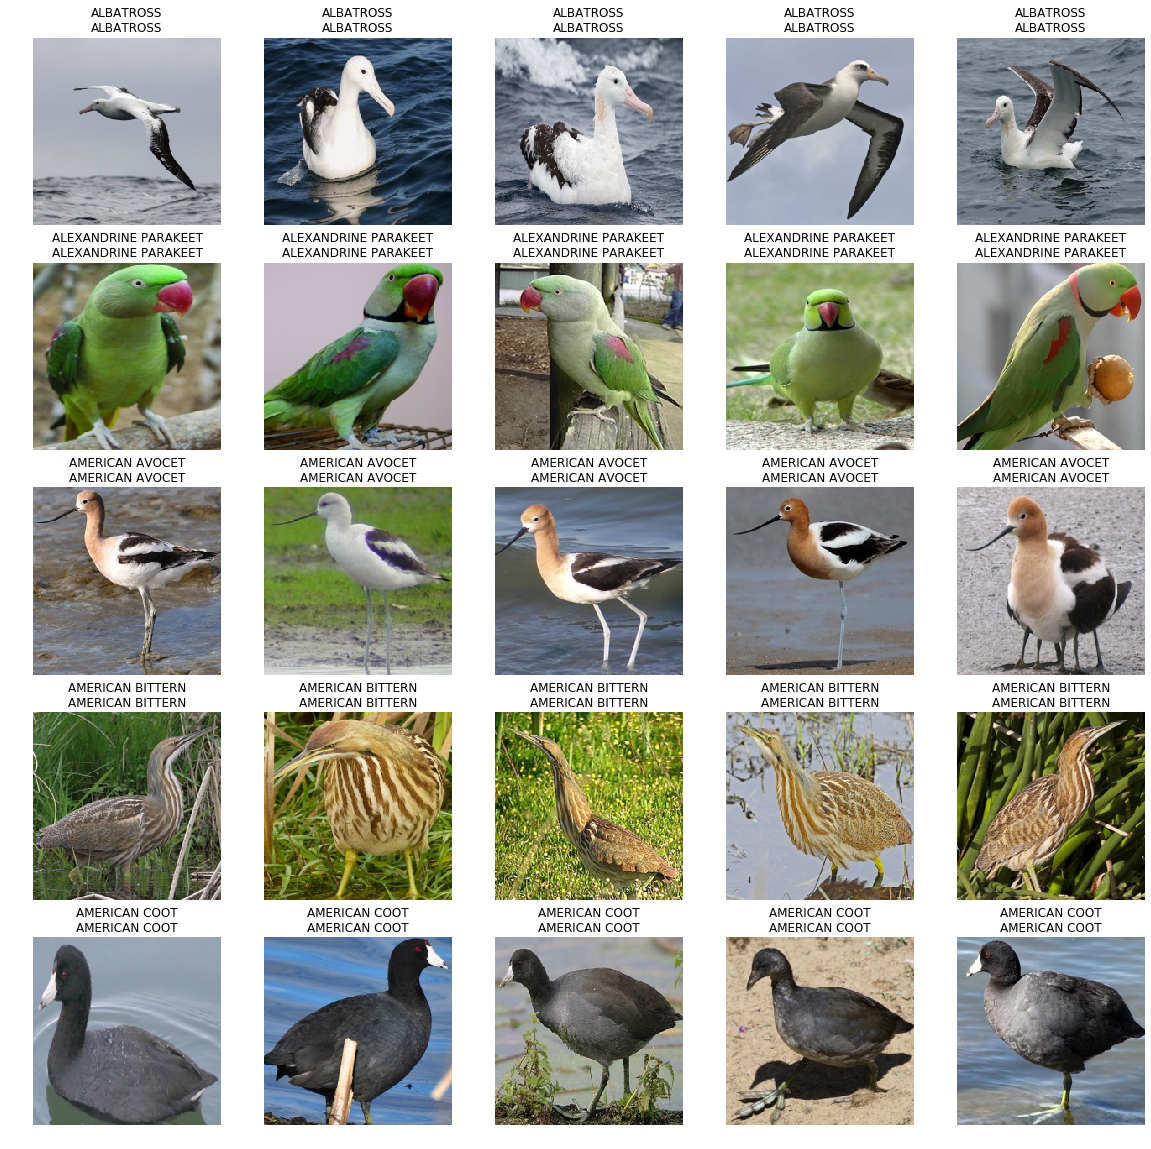

In [ ]:
# Title: Original vs Predicted 
vis_model(model_ft)